In [21]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim

plt.rcParams.update({'font.size': 22})
pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [22]:
data = simplesim.Manager( directory="./data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="diag", filetype="nc")
plot = simplesim.Manager( executable ="./feltorplot.sh", directory="plot", filetype = "nc")

In [60]:
content = data.table()
content.pop() # Temporary easy work with only one list element
print( f"The database contains {np.size(content)} elements")


The database contains 1 elements


In [24]:
config = fp.load_default_config()

with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [25]:
for file in content : 
    diag.create(file)
    plot.create(file)

### Mass flux out of separatrix

Invert for given numerical parameters
Average flux is 1.42e-03 pm 7.72e-04
Total average mass loss rate is 6975.3
Total mass gain by sources is 8387.4
particle confinement time = 5.99e+02


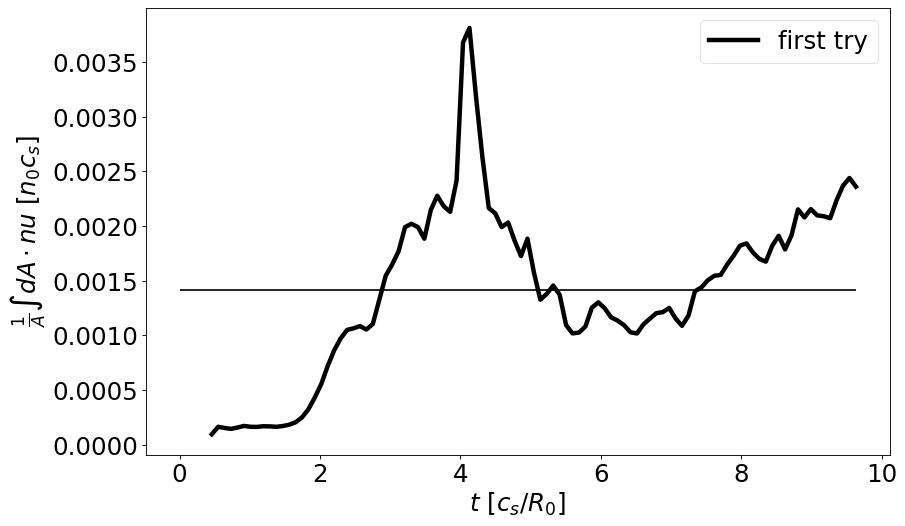

Average flux  [0.00141821]
Sigma flux  [0.00077195]
Confinement time  [0.03265039]


In [61]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion
min_idx = 5
confinement_time = np.array([])
average_flux = np.array([])
sigma_flux = np.array([])

fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :

    #dd = Dataset( data.outfile(file), 'r')
    da = Dataset( diag.outfile(file), "r")
    #pl = nc.Dataset( plot.outfile(file), "r")
    
    #print( dset)
    pp = json.loads( da.inputfile )
    time = da['time'][:]
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    rho = da['rho'][:]
    area = da['psi_area'][:]
    volume = da['psi_vol'][:]
    
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
#     print( pp["physical"])
    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    timescale = 1/num['R_0'] # R_0 / c_s
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =da['electrons_ifs_lcfs'][:]
    average_mass = np.mean(mass)
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    # jvne= dset.variables['jvneE_tt_fsa'][:,:]
    jvne=da['jvneC_tt_ifs_lcfs'][:]/deltat
    jvne+=da['jvneE_tt_ifs_lcfs'][:]/deltat
    jvne+=da['jvneA_tt_ifs_lcfs'][:]/deltat
    divjvne = da["divjnepar_tt_ifs_lcfs"][:]/deltat
    average_jvne = jvne[min_idx:].mean() # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    source = da["sne_tt_ifs_lcfs"][:]/deltat
    average_source = source[min_idx:].mean()
    print( f"Average flux is { average_jvne/area[167]:1.2e} pm {sigma_jvne/area[167]:1.2e}")
    print( f"Total average mass loss rate is {average_jvne:6.1f}")
    print( f"Total mass gain by sources is {average_source:6.1f}" )
    average_flux = np.append( average_jvne/area[167], average_flux )
    sigma_flux = np.append( sigma_jvne/area[167], sigma_flux )
    print( f"particle confinement time = {average_mass/average_jvne*timescale:1.2e}")
    confinement_time = np.append( average_mass/average_jvne*1e-7, confinement_time )
    tau = mass/jvne
    lcfs = np.argmax( rho_t[np.where( rho_t < 1)])
    idx = lcfs
    plt.plot(time[min_idx:]*timescale,jvne[min_idx:]/area[idx], color='k', 
             marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, label='first try')
    plt.hlines(average_jvne/area[idx], time[0]*timescale, time[len(time)-1]*timescale, color='k')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
plt.xlabel(r"$t\ [c_s/R_0]$")
plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")

plt.show(   )
print( "Average flux ", average_flux)
print( "Sigma flux ", sigma_flux)
print( "Confinement time ", confinement_time)

### Volume Integrated Mass conservation

Average diff =  -85.96573192027198


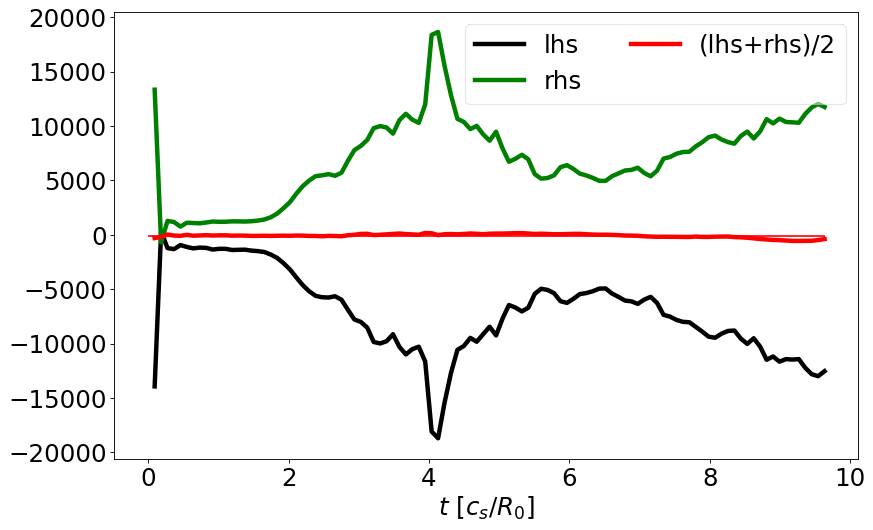

In [62]:
fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :

    dset = Dataset( diag.outfile(file), 'r')
    #print( dset)
    params = json.loads( dset.inputfile )
    time = dset['time'][:]
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    
    mass =dset.variables['electrons_ifs_lcfs'][:]
    masstt=np.append(np.zeros(1),mass, axis=0)

    deltamass = np.diff(masstt,axis=0)/deltat
    source = dset.variables['sne_tt_ifs_lcfs'][:]/deltat
    deltamass-=source
    jvne= dset['jvneE_tt_ifs_lcfs'][:]/deltat
    jvne+=dset['jvneC_tt_ifs_lcfs'][:]/deltat
    jvne+=dset['jvneA_tt_ifs_lcfs'][:]/deltat
    divjvnepar=dset['divjnepar_tt_ifs_lcfs'][:]/deltat
    #jvne+=divjvnepar

    diff_perp = dset["lneperp_tt_ifs_lcfs"][:]/deltat
    rhs = jvne-diff_perp
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean(diff[1:])
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,deltamass[1:], color='k', marker='',
              ls='-', lw=4,markeredgecolor='k', markersize=8, label="lhs")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=4,markeredgecolor='g', markersize=8, label="rhs")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=4,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
#     plt.plot(time[min_idx:]*timescale,divjvnepar[min_idx:], color='g', marker='',
#              ls='--', lw = 4, label="parallel")

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    
plt.xlabel(r"$t\ [c_s/R_0]$")

plt.show(   )

### Average FSA Mass conservation 

Average diff =  -3.065071533108233e-07
Average std  =  4.063731761773848e-06


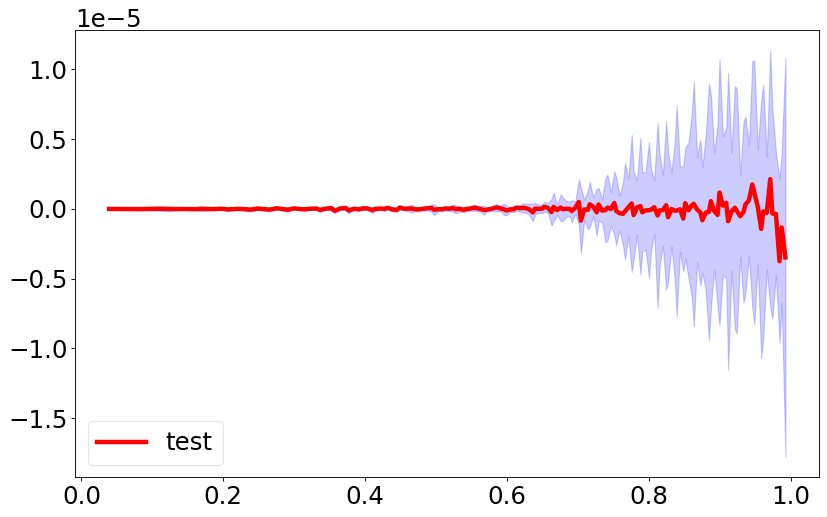

In [74]:
fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :

    dset = Dataset( diag.outfile(file), 'r')
    mass =dset.variables['electrons_fsa'][:,:]
    time = dset.variables['time'][:]
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    rho_t = dset.variables['rho_t'][:]
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = dset.variables['sne_tt_fsa'][:,:]/deltat[:,None]
    deltamass-=source

    jvneC=dset.variables['jvneC_tt_ifs'][:,:]/deltat[:,None]
    jvneE=dset.variables['jvneE_tt_ifs'][:,:]/deltat[:,None]
    jvneA=dset.variables['jvneA_tt_ifs'][:,:]/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = dset.variables["lneperp_tt_fsa"][:,:]/deltat[:,None]
    rhs = jvne-diff_perp
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])

    plt.plot( rho_t[0:167], average_diff[0:167], ls = '-', color='r', lw = 4, label = 'test')
    plt.fill_between( rho_t[0:167], average_diff[0:167]-average_std[0:167], 
                      average_diff[0:167]+average_std[0:167], color='b', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()

### Local Mass conservation on LCFS

Average diff =  -0.00016704639855439832
Average std  =  0.002214733810166747


Text(0.5, 0, '$t\\ [c_s/R_0]$')

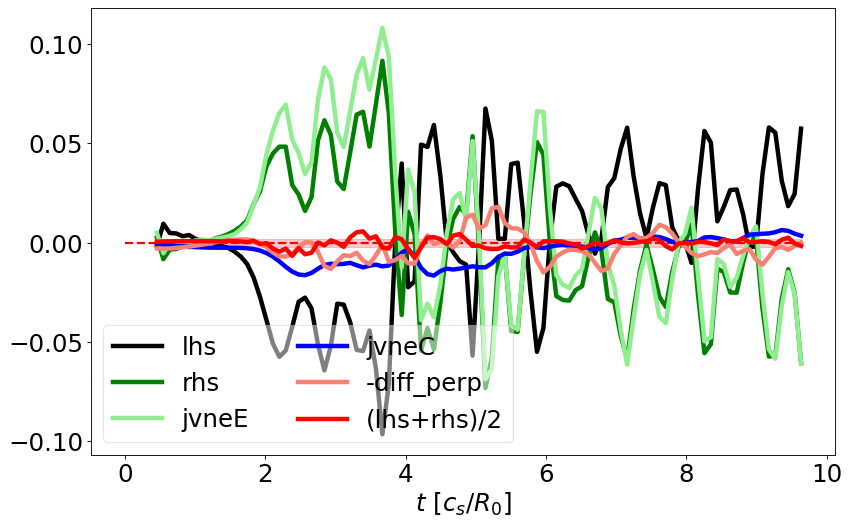

In [80]:
fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :

    dset = Dataset( diag.outfile(file), 'r')
    mass =dset.variables['electrons_fsa'][:,:]
    time = dset.variables['time'][:]*timescale
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    rho_t = dset.variables['rho_t'][:]
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = dset.variables['sne_tt_fsa'][:,:]/deltat[:,None]
    deltamass-=source

    jvneC=dset.variables['jvneC_tt_ifs'][:,:]/deltat[:,None]
    jvneE=dset.variables['jvneE_tt_ifs'][:,:]/deltat[:,None]
    jvneA=dset.variables['jvneA_tt_ifs'][:,:]/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = dset.variables["lneperp_tt_fsa"][:,:]/deltat[:,None]
    rhs = jvne-diff_perp
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    plt.plot(time[min_idx:],deltamass[min_idx:,idx], color='k', marker='',
              ls='-',lw=4, label="lhs")
    plt.plot(time[min_idx:],rhs[min_idx:,idx], color='g',
              ls='-', lw = 4,  label="rhs")
    plt.plot(time[min_idx:],jvneE[min_idx:,idx], color='lightgreen',
              ls='-', lw = 4, label="jvneE")
    plt.plot(time[min_idx:],jvneC[min_idx:,idx], color='blue',
              ls='-', lw = 4, label="jvneC")
    plt.plot(time[min_idx:],-diff_perp[min_idx:,idx], color='salmon',
              ls='-', lw = 4,  label="-diff_perp")
    plt.plot(time[min_idx:],diff[min_idx:,idx], color='r',
              ls='-', lw = 4,  label="(lhs+rhs)/2")
    plt.hlines(average_diff[idx], time[0], time[len(time)-1], color='r',ls='--', lw=2 )
    plt.fill_between( time[min_idx:], average_diff[idx]-average_std[idx], 
                      average_diff[idx]+average_std[idx], color='red', alpha=0.2)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
plt.xlabel(r"$t\ [c_s/R_0]$")

### Density profile

Dataset length  106
Average region  0.45871559633027525 9.63302752293578


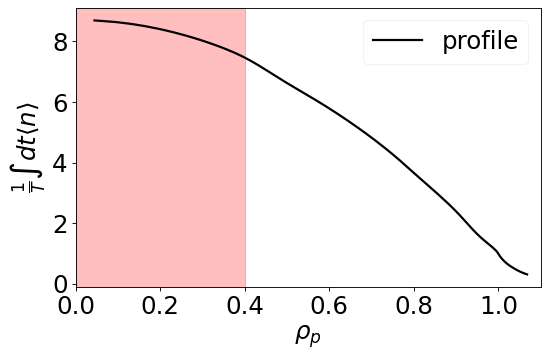

In [64]:

fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :

    dset = Dataset( diag.outfile(file), 'r')
    #print( dset)
    params = json.loads( dset.inputfile )

    time = dset.variables['time'][:]

    rho_t = dset.variables['rho_t'][:]
    rho_p = dset.variables['rho_p'][:]
    psi_p = dset.variables['psi_psi'][:]
    area = dset.variables['psi_area'][:]
    volume = dset.variables['psi_vol'][:]
    density =dset.variables['electrons_fsa'][:]
    source = dset.variables['sne_tt_fsa'][:]
    print( "Dataset length ", len(time))
    print( "Average region ", time[min_idx]*timescale, time[len(time)-1]*timescale)
    avg_density=density[min_idx:len(time)-1].mean(axis=0)
    avg_source = source.mean(axis=0)
    plt.plot( rho_p, avg_density, color='k', ls='-', lw=2, label='profile' )
    # plt.plot( rho_t, density[len(time)-1,:],color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( rho_t, avg_source*1000,color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( rho_t,   -psi_p*3+1, ls='--', color = 'k')
#     plt.plot( rho_p,   -psi_p/2+1, ls='--', color = 'k')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.25)
    dset.close()
ax.axvspan(0, 0.4, alpha=0.25, color='red')

plt.xlabel(r"$\rho_p$")
# plt.xlabel(r"$\sqrt{\psi_p/\psi_{O}}$")

plt.ylabel(r"$\frac{1}{T}\int dt \langle n\rangle$")
plt.xlim(0,1.1)
# plt.ylim(0,27)
# plt.ylim(0,30000)
plt.show(  )

### Vorticity accuracy on LCFS

Index 167 vs lcfs 167
167
0.9982504105290855
Average diff =  -2.0119541565635505e-07
Average std  =  4.2018672306354825e-06


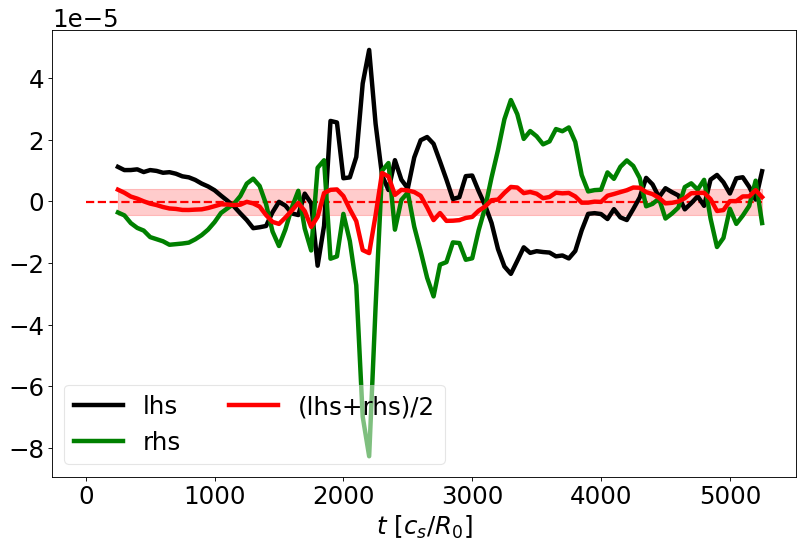

In [68]:
fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :

    dset = Dataset( diag.outfile(file), 'r')
    #print( dset)
    params = json.loads( dset.inputfile )
    time = dset.variables['time'][:]
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    rho_t = dset.variables['rho_t'][:]
    
#     vorticity = dset.variables['vorticity_fsa'][:,:]
#     el = dset.variables['electrons_ifs'][:,:]
#     ions = dset.variables['ions_ifs'][:,:]
#     dvdpsip=dset.variables['dvdpsi'][:]
#     vorticity = (el-ions)/dvdpsip
    vorticity =dset.variables['oexbe_fsa'][:,:]
    # vorticity+=dset.variables['odiae_fsa'][:,:]
    # vorticity/=dset.variables['electrons_fsa'][:,:]
    tttvorticity=np.append(np.zeros((1,len(rho_t))),vorticity, axis=0)
    deltavorticity = np.diff(tttvorticity,axis=0)/deltat[:,None]
    jvoE= dset.variables['jvoexbe_tt_ifs'][:,:]/deltat[:,None]
    jvoD= dset.variables['jvoexbeUD_tt_ifs'][:,:]/deltat[:,None]
    # jvoD= dset.variables['jvodiaeUE_tt_ifs'][:,:]/deltat[:,None]
    maxwell= dset.variables['jvoapar_tt_ifs'][:,:]/deltat[:,None]
    jvoA= dset.variables['jvoexbApar_tt_ifs'][:,:]/deltat[:,None]
    # jvoA= dset.variables['jvodiaApar_tt_ifs'][:,:]/deltat[:,None]
    jvo = jvoE + jvoD + maxwell + jvoA
    force = -dset.variables["socurve_tt_fsa"][:,:]/deltat[:,None]
    force -= dset.variables["socurvi_tt_fsa"][:,:]/deltat[:,None]
    force -= dset.variables["socurvkappae_tt_fsa"][:,:]/deltat[:,None]
    force -= dset.variables["socurvkappai_tt_fsa"][:,:]/deltat[:,None]
    # force2 = -dset.variables["curvne_tt_ifs"][:,:]/deltat[:,None]/dvdpsi[:]
    # source = dset.variables["sosne_tt_fsa"][:,:]/deltat[:,None]
    # source+= dset.variables["sospi_tt_fsa"][:,:]/deltat[:,None]
    # lamb = dset.variables["loexbe_tt_fsa"][:,:]/deltat[:,None]
    #lamb = dset.variables['lneperp_tt_ifs'][:,:]/deltat[:,None]

    #lamb = lamb/dvdpsip[None,:]

    rhs = jvo+force#-lamb#-source
    # diff = +deltavorticity + rhs
    diff = (deltavorticity +rhs)/2
    # delayed_diff = (deltavorticity[0:-1,:]+rhs[1:,:])/2
    average_diff = np.mean( diff[1:], axis=0)
    average_std = np.std( diff[1:], axis=0)
    # rhs = rhs - 2*average_diff[None, :]
    # diff = ( deltavorticity + rhs)/2
    
    lcfs = np.argmax( rho_t[np.where( rho_t < 1)])
    print( "Index 167 vs lcfs", lcfs)
    idx= 167
    print( idx)
    print( rho_t[idx])
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    plt.plot(time[min_idx:],deltavorticity[min_idx:,idx], color='k', marker='',
              ls='-',lw=4,markeredgecolor='k', markersize=8, label="lhs")
    plt.plot(time[min_idx:],rhs[min_idx:,idx], color='g', marker='',
              ls='-', lw = 4, markeredgecolor='k', markersize=8, label="rhs")
    plt.plot(time[min_idx:],diff[min_idx:,idx], color='r', marker='',
              ls='-', lw = 4, markeredgecolor='k', markersize=8, label="(lhs+rhs)/2")
#     plt.plot(time[min_idx:],10*jvoE[min_idx:,idx], color='salmon', marker='',
#               ls='-',lw=4,markeredgecolor='k', markersize=8, label="jvoE")
#     plt.plot(time[min_idx:],10*jvoD[min_idx:,idx], color='lightblue', marker='',
#               ls='-',lw=4,markeredgecolor='k', markersize=8, label="jvoD")
#     # plt.plot(time[min_idx:],-source[min_idx:,idx], color='crimson', marker='',
#     #           ls='-', lw = 4, markeredgecolor='k', markersize=8, label="-source")
#     plt.plot(time[min_idx:],force[min_idx:,idx], color='y', marker='',
#               ls='-', lw = 4, markeredgecolor='k', markersize=8, label="force")
#     plt.plot(time[min_idx:],jvoA[min_idx:,idx], color='orange', marker='',
#               ls='-', lw = 4, markeredgecolor='k', markersize=8, label="jvoA")
#     plt.plot(time[min_idx:],maxwell[min_idx:,idx], color='pink', marker='',
#               ls='-', lw = 4, markeredgecolor='k', markersize=8, label="Maxwell")
    # plt.plot(time[min_idx:],-lamb[min_idx:,idx], color='lightyellow', marker='',
    #           ls='-', lw = 4, markeredgecolor='k', markersize=8, label="-lambda")
    plt.hlines(average_diff[idx], time[0], time[len(time)-1], color='r',ls='--', lw=2 )
    plt.fill_between( time[min_idx:], average_diff[idx]-average_std[idx], 
                      average_diff[idx]+average_std[idx], color='red', alpha=0.2)

    # print(time[len(time)-1])
    # idx = np.where( time[np.where( time < 9356)]>9354)
    # print( idx[0][0] )
    # plt.plot( rho_t, force[ idx[0][0],: ], color='y', label = "force")
    # plt.plot( rho_t, jvo[ idx[0][0],: ], color='r', label = "jvo")
    # plt.plot( rho_t, deltavorticity[ idx[0][0],: ], color='g', label = "dO")
    
    
    # plt.plot( rho_t, average_diff, ls = '-', color=v[0], lw = 4, label = v[1])
    # plt.fill_between( rho_t[0:167], average_diff[0:167]-average_std[0:167], 
    #                   average_diff[0:167]+average_std[0:167], color=v[0], alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    
plt.xlabel(r"$t\ [c_s/R_0]$")
# plt.xlabel(r"$\rho_t$")
# plt.xlim(0,6)
# plt.ylabel(r"$\int dV \Omega_E$")
#plt.xlim(6360,6400)
# plt.xlim(0,1.0)
# plt.ylim(-2e-2,2e-2)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show(   )